In [15]:
# Import our beloved libraries
import glob
from music21 import converter, instrument, note, chord
import numpy as np
import tensorflow as tf
import tensorflow.keras.utils
import pickle
from music21 import *
import os
from music21 import stream
from tensorflow.keras.utils import to_categorical

In [ ]:
# FOR MUSECORE
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore
!apt-get install xvfb
!sh -e /etc/init.d/x11-common start
os.putenv('DISPLAY', ':99.0')
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

In [ ]:

# create note and chord objects based on the values generated by the model

def assembleSong(prediction_output,prediction_outputD,modelType):

  generatedStream = stream.Stream()
  # Define instrument
  generatedStream.append(instrument.Piano())
  offset = 0
  output_notes = []
  # traverse predictions of notes and durations
  for pattern,patternD in zip(prediction_output,prediction_outputD):

    # if its a chord or the note is still a digit 
    if ('.' in pattern) or pattern.isdigit():
        
          notes_in_chord = pattern.split('.')
          notes = []
          duration = []
          for current_note in notes_in_chord:
              # Depending of the model
              if (modelType == "LSTM"):
                new_note = note.Note(int(current_note))
              else:
                new_note = note.Note(current_note)
              notes.append(new_note)
          # keep generated chords and append them to the generated stream list
          new_chord = chord.Chord(notes)
          new_chord.offset = offset
          generatedStream.append(new_chord)
    else:
          # keep generated notes and append them to the generated stream list
          new_note = note.Note(pattern)
          new_note.offset = offset 
          generatedStream.append(new_note)

    offset += float(patternD)
  return generatedStream


In [ ]:
notes = []
durations=[]
notesWithChords=[]
original=[]
augmentedMidiList=[]
oChords = [[] for i in range(366)]
oDurations = [[] for i in range(366)]
i=0

# traverse the folder with the midi files
for file in glob.glob("/content/drive/MyDrive/blues/*.mid"):
    # parse the midi file
    midiA = converter.parse(file)
    augmentedMidiList=[]
    # keep our original file and augment the midi files by trasposing one semitone up and down 
    augmentedMidiList.append(midiA)
    augmentedMidiList.append(midiA.transpose(1))
    augmentedMidiList.append(midiA.transpose(-1))

    for midi in augmentedMidiList:
      notes_to_parse = None
      
      # FOR AUTOENCODER
      # if we have polyphonic tracks, zip simultaneously played notes into chords
      midiChord=midi.chordify()
      # extract notes and chords from each song and make a list
      for element in midiChord:
          if isinstance(element, note.Note):
              oChords[i].append(element.pitch)
          elif isinstance(element, chord.Chord):
              oChords[i].append('.'.join(str(n) for n in element.pitches))
      i=i+1
      # FOR LSTM
      # DIVIDE BY INSTRUMENT
      parts = instrument.partitionByInstrument(midi)

      if parts: # file has instrument parts
          notes_to_parse = parts.parts[0].recurse()
      else: # file has notes in a flat structure
          notes_to_parse = midi.flat.notes
            # extract notes ,chords, and quarterLengths from each song and make a list
      for element in notes_to_parse:
          if isinstance(element, note.Note):
              notes.append(str(element.pitch))
              durations.append(element.duration.quarterLength)
          elif isinstance(element, chord.Chord):
              notes.append('.'.join(str(n) for n in element.normalOrder))
              durations.append(element.duration.quarterLength)

***Load predefined variables extracted from the dataset with the corresponding augmentation depending of the model***

In [76]:
# LOAD DATA FOR LSTM
with open('notes.pickle', 'rb') as f:
  notes = pickle.load(f)
with open('durations.pickle', 'rb') as f:
  durations = pickle.load(f)

# LOAD DATA FOR AUTOENCODER
with open('oChords2.pickle', 'rb') as f:
  oChords = pickle.load(f)
with open('oDurations2.pickle', 'rb') as f:
  oDurations = pickle.load(f)


## **AUTOENCODER MODEL**

In [77]:
# keep unique chords and append them to a dictionary as integers
uniqueChords = np.unique([i for s in oChords for i in s])
chordToInt = dict(zip(uniqueChords, list(range(0, len(uniqueChords)))))

# Define sequence length of our song to be
sequenceLength = 40

trainChords = []


# Construct training sequences for chords
for s in range(len(oChords)):
    chordList = [chordToInt[c] for c in oChords[s]]
    for i in range(len(chordList) - sequenceLength):
        trainChords.append(chordList[i:i+sequenceLength])

In [78]:
# convert to numpy array
trainChords = np.array(trainChords, np.float)

# convert to categorical values and change positions of the dimensions
trainChords = tf.keras.utils.to_categorical(trainChords).transpose(0,2,1)

# define number of samples, chords and notes, and input dimension
nSamples = trainChords.shape[0]
nChords = trainChords.shape[1]
inputDim = nChords * sequenceLength

# set number of latent features
latentDim = 2

# flatten sequence of chords into single dimension
trainChordsFlat = trainChords.reshape(nSamples, inputDim)

In [58]:
# enconder input layer
encoderInput = tf.keras.layers.Input(shape = (inputDim))

# decoder ouput layer
latent = tf.keras.layers.Input(shape = (latentDim))

# dense encoding layer between input to latent 
encoded = tf.keras.layers.Dense(latentDim, activation = 'relu')(encoderInput)

# dense decoding layer between latent and output
decoded = tf.keras.layers.Dense(inputDim, activation = 'sigmoid')(latent)

# encoder and decoder
encoder = tf.keras.Model(encoderInput, encoded)
decoder = tf.keras.Model(latent, decoded)

# entire autoencoder model
autoencoder = tf.keras.Model(encoderInput, decoder(encoded))

In [ ]:
# Compile autoencoder
autoencoder.compile(loss = 'binary_crossentropy', optimizer='SGD')

# Train our model
autoencoder.fit(trainChordsFlat, trainChordsFlat, epochs = 100)

Epoch 1/7
1951/1951 [==============================] - 12s 6ms/step - loss: 0.0043
Epoch 2/7
1951/1951 [==============================] - 11s 6ms/step - loss: 0.0043
Epoch 3/7
1951/1951 [==============================] - 11s 6ms/step - loss: 0.0043
Epoch 4/7
1951/1951 [==============================] - 11s 6ms/step - loss: 0.0043
Epoch 5/7
1951/1951 [==============================] - 11s 6ms/step - loss: 0.0043
Epoch 6/7
1951/1951 [==============================] - 11s 6ms/step - loss: 0.0043
Epoch 7/7
1951/1951 [==============================] - 11s 6ms/step - loss: 0.0043


**To save or load the model**

In [56]:
!mkdir -p saved_model
# autoencoder.save('/content/drive/MyDrive/deepLearningModels/autoencoder2000DataAugGood') 
model = tensorflow.keras.models.load_model('/content/drive/MyDrive/deepLearningModels/autoencoder2000DataAugGood')

**Generate song from decoder**

In [71]:
modelType="AUTOENCODER"
# generate chords from decoder
generatedChords = decoder(np.random.normal(size=(1,latentDim))).numpy().reshape(nChords, sequenceLength).argmax(0)
#get string value of notes from int 
intToChord = {i: c for c, i in chordToInt.items()}
prediction_output = [intToChord[c] for c in generatedChords]
# fixed offset between notes at 0.5 s
prediction_outputD=[0.5 for i in range(len(prediction_output))]

In [81]:
# AUTONENCODER GENERATE NEW SONG
generatedStream=assembleSong(prediction_output,prediction_outputD,modelType)
# convert song to midi type and save it
generatedStream.write('midi', fp='testAutoEncoder32.mid') 

'autoencoderSong.mid'

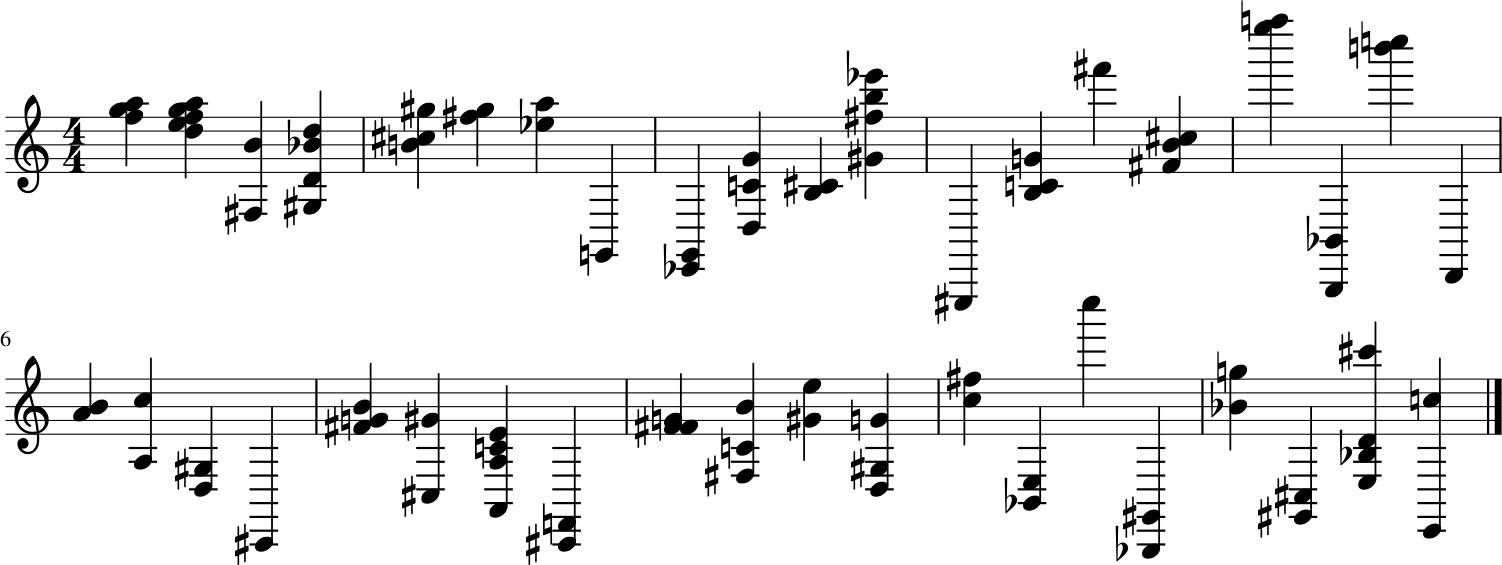

None


In [99]:
# Parse MIDI file and convert notes to chords
score = converter.parse('Autoencoder_Select.mid').chordify()]
# Display as shit music
print(score.show())

## **Long Short-Term Memory Neural Network**


In [4]:

sequence_length = 70

# get all pitch and duration names
pitchnames = sorted(set(item for item in notes))
durname=sorted(set(item for item in durations))
# get total number of pitchnames and durations
n_vocab=len(pitchnames)
d_vocab=len(durname)
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
dur_to_int = dict((durations, number) for number, durations in enumerate(durname))
network_input = []
network_inputDur= []
network_output = []
network_outputDur= []



# create input sequences and the corresponding outputs for the notes 
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
  
# create input sequences and the corresponding outputs for the durations 
for i in range(0, len(durations) - sequence_length, 1):
    sequence_din = durations[i:i + sequence_length]
    sequence_dout = durations[i + sequence_length]
    network_inputDur.append([dur_to_int[char] for char in sequence_din])
    network_outputDur.append(dur_to_int[sequence_dout])

n_patterns = len(network_input)
d_patterns= len(network_inputDur)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
network_inputDur = np.reshape(network_inputDur, (d_patterns, sequence_length, 1))

# normalize input
network_input = network_input / float(n_vocab)
network_inputDur = network_inputDur / float(d_vocab)
network_output = tensorflow.keras.utils.to_categorical(network_output)
network_outputDur = tensorflow.keras.utils.to_categorical(network_outputDur)

In [5]:
# Define input layers

chordInput = tf.keras.layers.Input(shape = (network_input.shape[1], network_input.shape[2]))
durationInput = tf.keras.layers.Input(shape = (network_inputDur.shape[1], network_inputDur.shape[2]))
print(chordInput)
print(durationInput)
# lstm and dropout layer for chords
lstmLayerChords = tf.keras.layers.LSTM(512,return_sequences=True)(chordInput)
dropOutChords = tf.keras.layers.Dropout(0.1)(lstmLayerChords)
# lstm and dropout layer for durations
lstmLayerDur= tf.keras.layers.LSTM(512,return_sequences=True)(durationInput)
dropOutDur= tf.keras.layers.Dropout(0.1)(lstmLayerDur)
print(lstmLayerChords)
print(dropOutChords)
print(lstmLayerDur)
print(dropOutDur)


# Merge embedding layers using a concatenation layer
mergeLayer = tf.keras.layers.Concatenate(axis=1)([dropOutChords, dropOutDur])
print(mergeLayer)


# Define LSTM layer
lstmLayer = tf.keras.layers.LSTM(512)(mergeLayer)
denseLayer = tf.keras.layers.Dense(256)(lstmLayer)
print(lstmLayer)
print(denseLayer)
# Define output layers
chordOutput = tf.keras.layers.Dense(n_vocab, activation = 'softmax',name="chords")(denseLayer)
durationOutput = tf.keras.layers.Dense(d_vocab, activation = 'softmax',name="durations")(denseLayer)

print(chordOutput)
print(durationOutput)
# Define model
lstm = tf.keras.Model(inputs = [chordInput, durationInput], outputs = [chordOutput, durationOutput])

KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")
KerasTensor(type_spec=TensorSpec(shape=(None, 308), dtype=tf.float32, name=None), name='chords/Softmax:0', description="created by layer 'chords'")
KerasTensor(type_spec=TensorSpec(shape=(None, 59), dtype=tf.float32, name=None), name='durations/Softmax:0', description="created by layer 'durations'")


In [6]:
# Define different loses
losses = {
	"chords": "categorical_crossentropy",
	"durations": "categorical_crossentropy",
}
# Complile our model
lstm.compile(loss=losses, optimizer='SGD')
# Train our model
modelType="LSTM"
lstm.fit(x=[network_input,network_inputDur],y=[network_output,network_outputDur], epochs=100, batch_size=50)

Epoch 1/100
2079/2079 [==============================] - 125s 58ms/step - loss: 6.7644 - chords_loss: 4.4029 - durations_loss: 2.3614
Epoch 2/100
2079/2079 [==============================] - 119s 57ms/step - loss: 6.5808 - chords_loss: 4.2860 - durations_loss: 2.2948
Epoch 3/100
2079/2079 [==============================] - 120s 58ms/step - loss: 6.5521 - chords_loss: 4.2813 - durations_loss: 2.2708
Epoch 4/100
2079/2079 [==============================] - 120s 58ms/step - loss: 6.3734 - chords_loss: 4.2283 - durations_loss: 2.1451
Epoch 5/100
2079/2079 [==============================] - 119s 57ms/step - loss: 6.2994 - chords_loss: 4.2003 - durations_loss: 2.0991
Epoch 6/100
2079/2079 [==============================] - 119s 57ms/step - loss: 6.2657 - chords_loss: 4.1807 - durations_loss: 2.0850
Epoch 7/100
2079/2079 [==============================] - 119s 57ms/step - loss: 6.2270 - chords_loss: 4.1569 - durations_loss: 2.0701
Epoch 8/100
2079/2079 [==============================] - 120s 

**Save or load Model**

In [27]:
!mkdir -p saved_model
lstm.save('/content/drive/MyDrive/deepLearningModels/finalLstmModel20') 
# lstm = tensorflow.keras.models.load_model('/content/drive/MyDrive/deepLearningModels/10epochModel')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/deepLearningModels/finalLstmModel20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deepLearningModels/finalLstmModel20/assets


**To generate song from lstm**

In [46]:
# FOR LSTM ONLY
# A model to predict two outputs

# Get random position of notes and durations
start = np.random.randint(0, len(network_input)-1)
startD = np.random.randint(0, len(network_inputDur)-1)
# Convert notes and durations to int 
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
int_to_dur = dict((number, durations) for number, durations in enumerate(durname))


print(type(network_input))
# Take the random note
pattern = network_input[start]
patternD = network_inputDur[startD]

prediction_outputD = []
prediction_output = []
prediction=[]
# generate 500 notes
for note_index in range(500):
    # Reshape inputs for prediction and normalize
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction_inputD = np.reshape(patternD, (1, len(patternD), 1))
    prediction_inputD = prediction_input / float(d_vocab)
    # PREDICTION
    prediction = lstm.predict(x=[prediction_input,prediction_inputD], verbose=1)
    # Get max values 
    index = np.argmax(prediction[0])
    indexD = np.argmax(prediction[1])
    # convert them to readable format
    result = int_to_note[index]
    resultD = int_to_dur[indexD]
    # make lists of your predicted notes
    prediction_output.append(result)
    prediction_outputD.append(resultD)
    pattern=np.append(pattern , index)
    patternD=np.append(patternD , indexD)
    pattern = pattern[1:len(pattern)]
    patternD = patternD[1:len(patternD)]

<class 'numpy.ndarray'>
1/1 [==============================] - 0s 18ms/step


** Assemble Song and convert into midi**

In [83]:
# LSTM GENERATE
generatedStream=assembleSong(prediction_output,prediction_outputD,modelType)
generatedStream.write('midi', fp='testLstm57.mid') 

'testLstm57.mid'

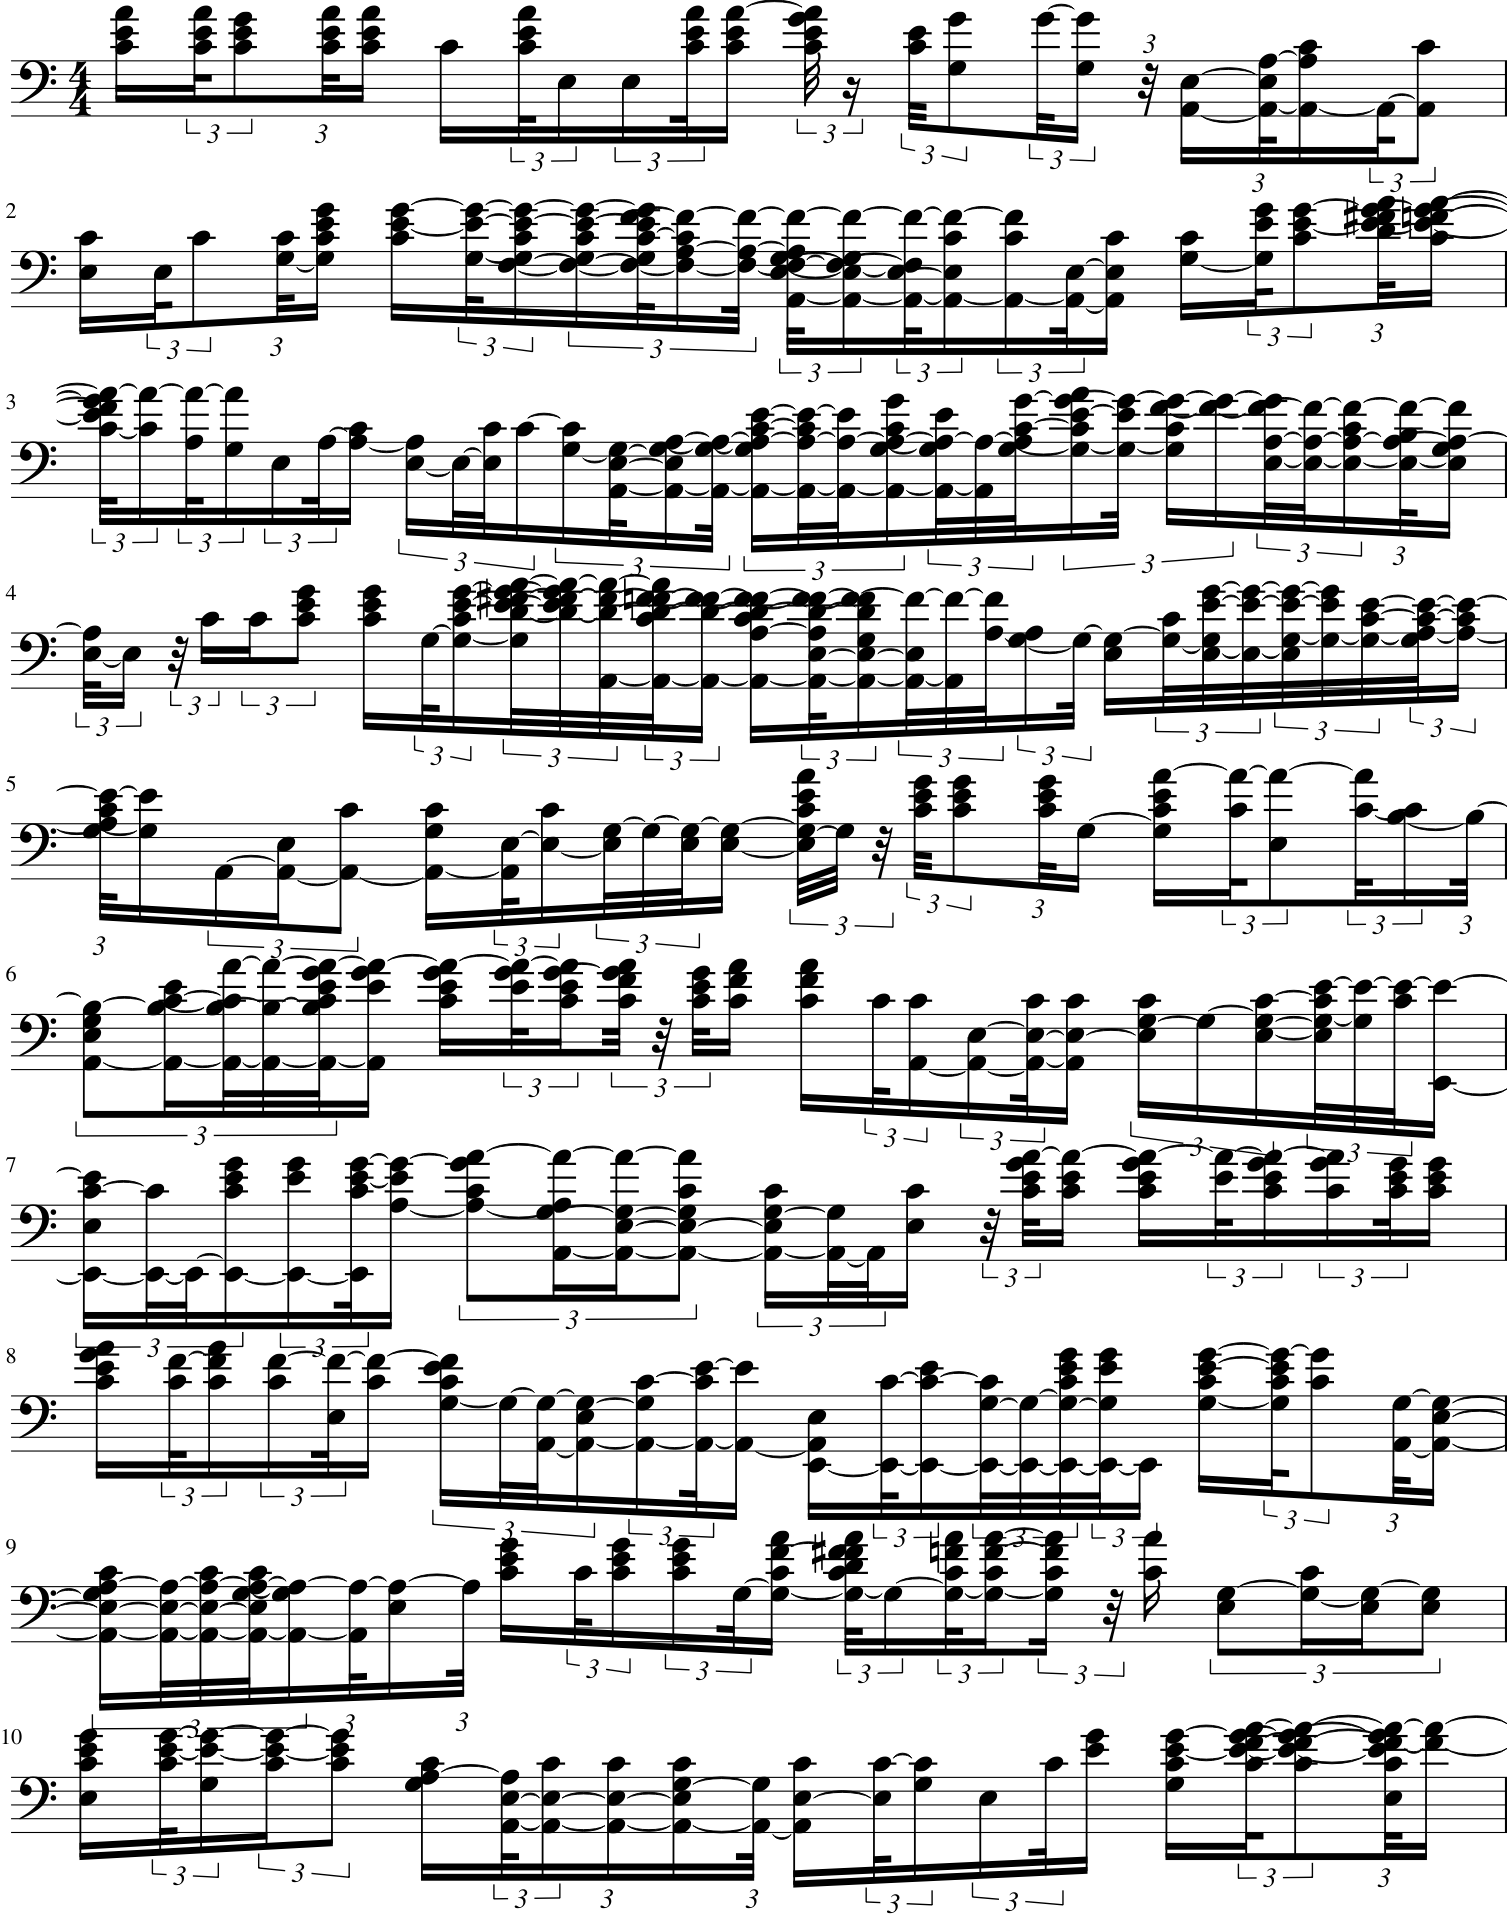

None


In [86]:
# Parse MIDI file and convert notes to chords
score = converter.parse('LSTM_Select2.mid').chordify()

# Display as shit music
print(score.show())